In [1]:
# imports and wandb login
import wandb, os, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import numpy as np, copy, torch
from tqdm import tqdm

sns.set_style("ticks")
os.environ["WANDB_NOTEBOOK_NAME"] = "xslorenz_KCroberta_betterserialization_results.ipynb"
wandb.login()

wandb: Currently logged in as: golkar. Use `wandb login --relogin` to force relogin


True

## Exploring the performance of the best trained model

In [2]:
# Loading the best trained model and the dataset

from transformers import PreTrainedTokenizerFast
from datasets import DatasetDict

best_run_path = "/mnt/home/sgolkar/ceph/saves/xslorenz/KCroberta/wandb/run-20230614_215115-s87k0h4h/files/model/model_torch_save.pkl"

# model = KCRobertaForMaskedLM.from_pretrained(best_run_path).cuda()
# model.power_num = 1/3
# model.roberta.embeddings.power_num = 1/3

model = torch.load(best_run_path).cuda()
model.eval()

tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer.json",
    bos_token="[END]",
    eos_token="[END]",
    mask_token="?",
    pad_token="[PAD]",
)

vocab_size = len(tokenizer.vocab)

### We look at the performance of the model at predicting the first Lorenz parameter.

In [13]:
# Loading the dataset

ds_path = "/mnt/home/sgolkar/ceph/datasets/microcosm/lorenz_world_xsmall/clean/"
tokenized_ds = DatasetDict.load_from_disk(ds_path + "numenc_shortbrack_xslorenz_ds")
# delete the train key of tokenized_ds to save time
del tokenized_ds['train']

num_token = tokenizer.encode('#')[0]
mask_token = tokenizer.encode('?')[0]

In [14]:
# showing the sample structure
sample = tokenized_ds["val"][0]

for i, el in enumerate(sample['input_ids'][:20]):
    print(i, [el], tokenizer.decode(el))

0 [0] {
1 [19] 'description':
2 [0] {
3 [16] 'num_sys':
4 [7] #
5 [4] ,
6 [11] 'sys0':
7 [0] {
8 [17] 'params':
9 [32] one_op
10 [7] #
11 [7] #
12 [7] #
13 [31] one_cl
14 [4] ,
15 [21] 'init_point':
16 [32] one_op
17 [7] #
18 [7] #
19 [7] #


In [23]:
# Writing a function that masks out the first Lorenz parameter
# the first lorenz parameter is always in position 10

retokenize = False

def mask_nth_param(sample, n = 10, device = 'cpu'):
    masked_sample = copy.deepcopy(sample)
    masked_sample['input_ids'][n] = mask_token
    len_ = len(masked_sample['input_ids'])
    masked_sample['masked_numbers'] = copy.deepcopy(sample['numbers'])[:len_]
    masked_sample['numbers'] = masked_sample['numbers'][:len_]
    masked_sample['labels'] = sample['input_ids']
    masked_sample['masked_numbers'][n] = 1.0
    # Next two lines are for calculating the correct mlm loss
    # tells the model to only look at the masked token for calculating x-entropy
    masked_sample['labels'] = list(0*np.array(masked_sample['labels'])-100)
    masked_sample['labels'][n] = sample['input_ids'][n]
    masked_sample['text'] = tokenizer.decode(sample['input_ids'])
    masked_sample['masked_text'] = tokenizer.decode(masked_sample['input_ids'])
    masked_sample['ans'] = masked_sample['numbers'][n].item()
    
    return masked_sample



test_mode = False
if test_mode:
    ds_to_tokenize = tokenized_ds["test"].train_test_split(test_size=1, train_size=100, seed=42)
else:
    ds_to_tokenize = tokenized_ds["test"].train_test_split(test_size=10_000, train_size=10_000, seed=42)

if retokenize:
    # Tokenizing the dataset and saving it
    masked_ds = ds_to_tokenize.map(mask_nth_param, batched=False, num_proc=30)
    masked_ds.save_to_disk(ds_path + "numenc_shortbrack_xslorenz_ds_mask10")
else:
    # Loading the tokenized dataset
    masked_ds = DatasetDict.load_from_disk(ds_path + "numenc_shortbrack_xslorenz_ds_mask10")


Map (num_proc=30):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=30):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

#### An example of the mask-filling problem

In [24]:
# An example of the masking

# remember train/test are all coming from test now.
masked_sample = masked_ds["train"][0]

print('original text: \n', masked_sample['text'])
print('original numbers: \n', masked_sample['numbers'])

print()

print('masked text: \n', masked_sample['masked_text'])
print('masked numbers: \n', masked_sample['masked_numbers'])
print('length of the tokenized sample: ', len(masked_sample['input_ids']))

print()
print('The number {} is replaced with 1.0.'.format(masked_sample['ans']))

original text: 
 {'description':{'num_sys':#,'sys0':{'params':one_op###one_cl,'init_point':one_op###one_cl,'step_size':#,'name':'lorenz','step_multip':#},'normalization':two_op###one_comma###two_cl,'embedding':thr_op###one_comma###one_comma###two_cl,one_op###one_cl,two_op######one_comma######one_comma######thr_cl},'data':two_op######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######one_comma######two_cl}
original numbers: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 9

In [25]:
# defining a prediction function

def predict(model, masked_sample, device = 'cuda'):
    model.to(device)
    out = model(
            input_ids = torch.tensor(masked_sample['input_ids']).view(1,-1).to(device),
            labels = torch.tensor(masked_sample['labels']).view(1,-1).to(device),
            numbers = torch.tensor(masked_sample['masked_numbers']).view(1,-1).to(device),
            masked_numbers = torch.tensor(masked_sample['masked_numbers']).view(1,-1).to(device)
            )
    return out

predicted token:  #
masked token: ?
actual token: #

predicted number: 9.52
masked number: 1.00
actual number: 9.23

losses:
mlm loss: 1.19e-07
numbers loss: 0.00271



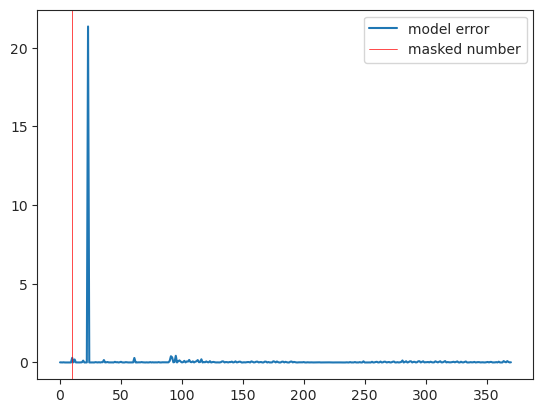

In [26]:
# remember train/test are all coming from test now.

masked_sample = masked_ds["train"][0]
model.eval()
device = model.device
out = predict(model, masked_sample, device)

print('predicted token: ', tokenizer.decode([out.logits[0,10].argmax().item()]))
print('masked token:', tokenizer.decode(masked_sample['input_ids'][10]))
print('actual token:', tokenizer.decode(masked_sample['labels'][10]))
print()
print('predicted number: {:.2f}'.format(out.numbers[0,10].item()))
print('masked number: {:.2f}'.format(masked_sample['masked_numbers'][10]))
print('actual number: {:.2f}'.format(masked_sample['numbers'][10]))

print()
print('losses:')
print('mlm loss: {:.3g}'.format(out.loss_mlm.item()))
print('numbers loss: {:.3g}'.format(out.loss_numbers.item()))

print()
# Even though only the first parameter is masked, the model still makes errors on other parameters
diff = np.abs((out.numbers[0]).detach().cpu().numpy() - np.array(masked_sample['numbers']))
plt.plot(diff, label='model error')
plt.axvline(10, color = 'r', linewidth = .5, label = 'masked number')
plt.legend();

#### How well does it perform quantitatively?

We look at the MSE.

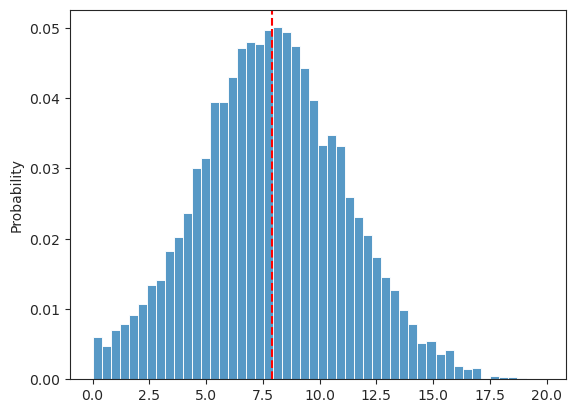

In [27]:
# Looking at the distribution of the answers in the train and test sets to set up a baseline

ans_dist_train = np.array(masked_ds["train"]["ans"])
ans_mean_train = np.mean(ans_dist_train)
sns.histplot(ans_dist_train, stat="probability")
plt.axvline(ans_mean_train, color="red", linestyle="--")
plt.show();

Computing the output of the model over the test set. The results are saved to preds_anss_probs.npz.

In [28]:
recompute_answers = False

if recompute_answers:

    preds = []
    anss = []

    device = model.device

    try:
        for masked_sample in tqdm(masked_ds["test"]):

            out = predict(model, masked_sample, device)
            
            anss.append(masked_sample["ans"])
            preds.append(out.numbers[0,10].item())
    except KeyboardInterrupt:
        pass
        
    preds = np.array(preds)
    anss = np.array(anss)

    # save preds, anss to numpy file
    np.savez(
        "./KC_preds_anss_better_serialization.npz",
        preds=preds,
        anss=anss,
    )
else:
    # load preds, anss, probs from numpy file
    preds_anss = np.load("./KC_preds_anss_better_serialization.npz")

    anss = preds_anss["anss"]
    preds = preds_anss["preds"]

100%|██████████| 10000/10000 [01:26<00:00, 115.22it/s]


NameError: name 'preds_anss' is not defined

RMSE performance comparison:

The learned model is usually within ±1 of the real answer.

In [10]:
print("baseline RMSE: {:.2f}".format(np.sqrt(np.mean((anss -anss.mean()) ** 2))))
print("learned RMSE: {:.2f}".format(np.sqrt(np.mean((anss - preds) ** 2))))

baseline RMSE: 3.20
learned RMSE: 0.50


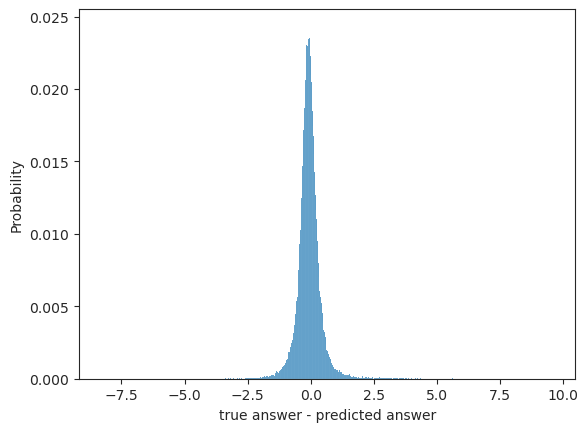

In [11]:
# sns histogram of the difference between true answer and the predicted answer
# set sns histogram bar width to 1
sns.histplot(anss - preds, stat="probability", discrete=False)
plt.xlabel("true answer - predicted answer");


Text(0.5, 1.0, 'true answer vs model prediction')

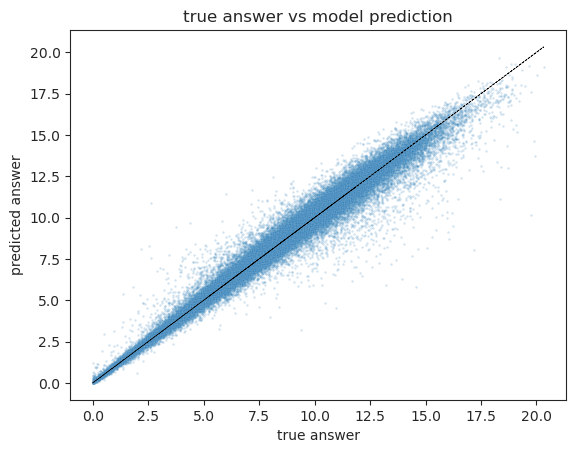

In [27]:
plt.plot(anss, anss, color="k", linestyle="--", linewidth=0.5)
sns.scatterplot(x=anss, y=preds, alpha=0.2, s=3)
plt.xlabel("true answer")
plt.ylabel("predicted answer")
plt.title("true answer vs model prediction")

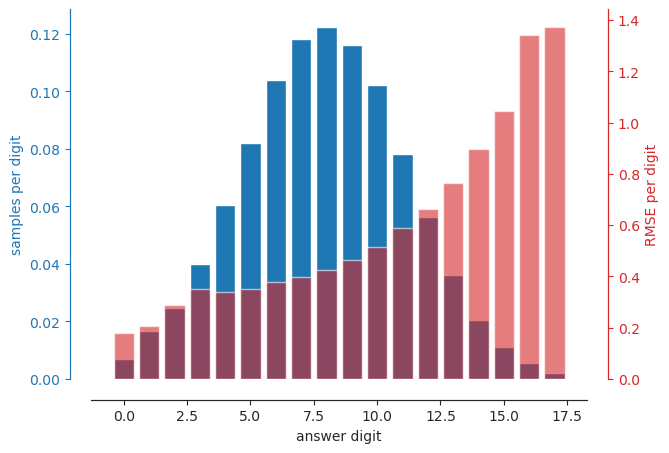

In [5]:
plt.bar(range(18), [(np.abs(anss - digit)<= 0.5).sum()/len(anss) for digit in range(18)])
plt.xlabel("answer digit")
plt.ylabel("samples per digit", color="tab:blue")
# change the color of the left axis to tab:blue
plt.gca().tick_params(axis='y', colors='tab:blue')
plt.gca().spines["left"].set_color("tab:blue")   
ax2 = plt.twinx()
ax2.bar(range(18), [np.sqrt(((anss[np.abs(anss - digit)<= 0.5] - preds[np.abs(anss - digit)<= 0.5])**2).mean()) for digit in range(18)], alpha=0.6, color="tab:red")
ax2.set_ylabel("RMSE per digit", color="tab:red")
ax2.tick_params(axis='y', colors='tab:red')
ax2.spines["right"].set_color("tab:red")

plt.gca().spines["left"].set_color("tab:blue")

# sns despine the top axis only
sns.despine(offset=15, top=True, right=False, left=False, bottom=False)

### Some interesting observations

The model has learned the effect of the step-size-multiplier in the parameters and updates appropriately its belief when we change this parameter:

correct answer: 6.26953125 

step multiplier = 4.0 (actual value)
model prediction: 6.27

step multiplier = 2.0 (smaller value)
model prediction: 8.80

step multiplier = 8.0 (larger value)
model prediction: 3.05



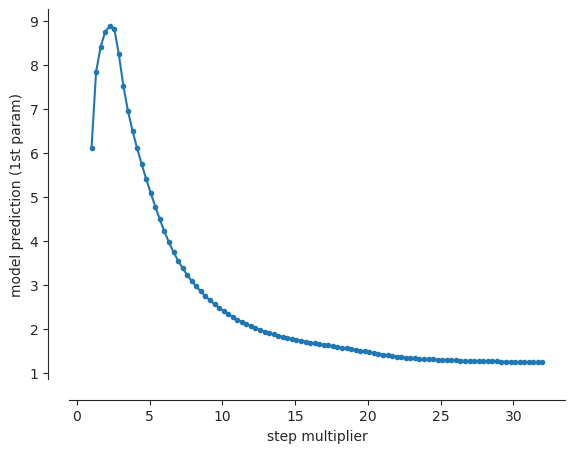

In [14]:
masked_sample = masked_ds["test"][21]

print("correct answer:", masked_sample["ans"], '\n')

print('step multiplier = {} (actual value)'.format(masked_sample['numbers'][33]))

out = predict(model, masked_sample, device)
print('model prediction: {:.2f}\n'.format(out.numbers[0,10].item()))


masked_sample['masked_numbers'][33] = 2.0
print('step multiplier = {} (smaller value)'.format(masked_sample['masked_numbers'][33]))
out = predict(model, masked_sample, device)
print('model prediction: {:.2f}\n'.format(out.numbers[0,10].item()))


masked_sample['masked_numbers'][33] = 8.0
print('step multiplier = {} (larger value)'.format(masked_sample['masked_numbers'][33]))
out = predict(model, masked_sample, device)
print('model prediction: {:.2f}\n'.format(out.numbers[0,10].item()))

step_multips = np.linspace(1, 32, 100)
predictions = []
for step_multip in step_multips:
    masked_sample['masked_numbers'][33] = step_multip
    out = predict(model, masked_sample, device)
    predictions.append(out.numbers[0,10].item())
plt.plot(step_multips, np.array(predictions), '-o', color='tab:blue', ms=3)

sns.despine(offset=15)
plt.xlabel('step multiplier')
plt.ylabel('model prediction (1st param)');


In [15]:
# Masking out the step multiplicity
masked_sample = masked_ds["test"][21]

print('Correct step_multip: {:.1f}'.format(masked_sample['numbers'][33]))
print('Correct 1st param: {:.2f}'.format(masked_sample['numbers'][10]))

masked_sample['masked_numbers'][33] = 1.0
masked_sample['input_ids'][33] = tokenizer.mask_token_id

print()
out = predict(model, masked_sample, device)

print('prediction for step_multip: {:.1f}'.format(out.numbers[0,33].item()))
print('prediction for 1st param: {:.2f}'.format(out.numbers[0,10].item()))

Correct step_multip: 4.0
Correct 1st param: 6.27

prediction for step_multip: 4.0
prediction for 1st param: 6.22


In [16]:
# Functions needsed to deal with new sample from the simulator

import re

reg_ex = r"(-\d+\.\d+e-\d+)|(-\d+\.\d+e\d+)|(\d+\.\d+e-\d+)|(\d+\.\d+e\d+)|(-\d+e-\d+)|(-\d+e\d+)|(\d+e-\d+)|(\d+e\d+)|(-\d+\.\d+)|(\d+\.\d+)|((?<!sys)\d+)"


def replace_numbers(text):
    text = re.sub(reg_ex, "#", text)
    return text


def find_numbers(text):
    return [eval("".join(el)) for el in re.findall(reg_ex, text)]


def reconstruct_numbers(text, numbers):
    for number in numbers:
        text = text.replace("#", str(number), 1)
    return text

max_len = 1150
def tokenize_fnc(sample):
    text = sample["text"].replace(" ", "")
    replaced_text = replace_numbers(text)
    out = tokenizer(replaced_text)
    ids = np.array(out["input_ids"])
    ids = np.pad(ids, (0, max_len - len(ids)), "constant", constant_values=-1)
    locs = ids == num_token
    num_embed = np.ones(max_len).astype(np.float16)
    num_embed[locs] = find_numbers(text)
    out["numbers"] = num_embed
    return out

In [17]:
import microcosm
text_sample = {}
text_sample['text'] = str(microcosm.sample_world(
        to_list=True,
        graceful_fail=True,
        seed=1,
        num_steps=40,
        max_dim=10,
        max_sys=2,
        step_multip=3
    )).replace(' ','')

sample = tokenize_fnc(text_sample)

masked_sample = mask_nth_param(sample, 33, device)

print('Correct step_multip: {:.1f}'.format(masked_sample['numbers'][33]))
out = predict(model, masked_sample, device)
print('prediction for step_multip: {:.1f}'.format(out.numbers[0,33].item()))

Correct step_multip: 3.0
prediction for step_multip: 3.0


In [18]:
import microcosm
text_sample = {}
text_sample['text'] = str(microcosm.sample_world(
        to_list=True,
        graceful_fail=True,
        seed=1,
        num_steps=40,
        max_dim=10,
        max_sys=2,
        step_multip=5
    )).replace(' ','')

sample = tokenize_fnc(text_sample)

masked_sample = mask_nth_param(sample, 33, device)

print('Correct step_multip: {:.1f}'.format(masked_sample['numbers'][33]))
out = predict(model, masked_sample, device)
print('prediction for step_multip: {:.1f}'.format(out.numbers[0,33].item()))

Correct step_multip: 5.0
prediction for step_multip: 5.0


In [47]:
# Looking at different lengths
import microcosm
text_sample = {}
text_sample['text'] = str(microcosm.sample_world(
        to_list=True,
        graceful_fail=True,
        seed=1,
        num_steps=30,
        max_dim=10,
        max_sys=2,
        step_multip=4
    )).replace(' ','')

sample = tokenize_fnc(text_sample)

masked_sample = mask_nth_param(sample, 33, device)

print('Correct step_multip: {:.1f}'.format(masked_sample['numbers'][33]))
out = predict(model, masked_sample, device)
print('prediction for step_multip: {:.1f}'.format(out.numbers[0,33].item()))

Correct step_multip: 4.0
prediction for step_multip: 3.0


In [52]:
# Looking at different lengths
import microcosm
text_sample = {}
text_sample['text'] = str(microcosm.sample_world(
        to_list=True,
        graceful_fail=True,
        seed=2,
        num_steps=40,
        max_dim=6,
        max_sys=4,
        step_multip=4
    )).replace(' ','')
sample_dict = eval(text_sample['text'])
print('data shape: ', np.array(sample_dict['data']).shape)
print('num sys: ', sample_dict['description']['num_sys'])

sample = tokenize_fnc(text_sample)

masked_sample = mask_nth_param(sample, 33, device)

print('Correct step_multip: {:.1f}'.format(masked_sample['numbers'][33]))
out = predict(model, masked_sample, device)
print('prediction for step_multip: {:.1f}'.format(out.numbers[0,33].item()))

data shape:  (40, 5)
num sys:  4
Correct step_multip: 4.0
prediction for step_multip: 33.2


In [33]:
# Looking at different lengths
import microcosm
text_sample = {}
text_sample['text'] = str(microcosm.sample_world(
        to_list=True,
        graceful_fail=True,
        seed=1,
        num_steps=40,
        max_dim=12,
        max_sys=2,
        step_multip=4
    )).replace(' ','')

sample = tokenize_fnc(text_sample)

masked_sample = mask_nth_param(sample, 10, device)

print('Correct 1st param: {:.1f}'.format(masked_sample['numbers'][10]))
out = predict(model, masked_sample, device)
print('prediction for 1st param: {:.1f}'.format(out.numbers[0,10].item()))

Correct 1st param: 10.6
prediction for 1st param: 11.1
